# NBA MVP Prediction Using Machine Learning
This notebook follows the same structure as `mvp_prediction.py`, loading data, preprocessing, training three models (Logistic Regression, Random Forest, XGBoost), evaluating them, plotting ROC curves, and running SHAP interpretability.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

# Load player-season dataset
nba_df = pd.read_csv("data/NBA_Dataset.csv")
nba_df["player"] = nba_df["player"].str.strip()
nba_df["season"] = nba_df["season"].astype(int)

# Load MVP voting data
mvp_2001_2010 = pd.read_csv("data/2001-2010 MVP Data.csv")
mvp_2010_2021 = pd.read_csv("data/2010-2021 MVP Data.csv")
mvp_2022_2023 = pd.read_csv("data/2022-2023 MVP Data.csv")
mvp_all = pd.concat([mvp_2001_2010, mvp_2010_2021, mvp_2022_2023], ignore_index=True)
mvp_all["player"] = mvp_all["Player"].str.strip()
mvp_all["season"] = mvp_all["year"].astype(int)
mvp_all["Rank"] = pd.to_numeric(mvp_all["Rank"], errors="coerce")
mvp_all["label"] = mvp_all["Rank"].apply(lambda r: 1 if r == 1 else (2 if r <= 3 else (3 if r <= 10 else 0)))
mvp_labels = mvp_all[["season", "player", "label"]]

# Load RAPTOR data and merge
rap_h = pd.read_csv("data/historical_RAPTOR_by_player.csv")
rap_m = pd.read_csv("data/modern_RAPTOR_by_player.csv")
rap_cols = ["player_name", "season", "raptor_offense", "raptor_defense", "raptor_total"]
rap = pd.concat([rap_h[rap_cols], rap_m[rap_cols]], ignore_index=True)
rap = rap.drop_duplicates(subset=["player_name", "season"])
rap = rap.rename(columns={"player_name": "player"})

# Merge datasets
bb = nba_df.copy()
df = bb.merge(rap, on=["season", "player"], how="left").merge(mvp_labels, on=["season", "player"], how="left")
df["label"] = df["label"].fillna(0).astype(int)
df = df[(df["season"] >= 2001) & (df["season"] <= 2022) & (df["mp"] >= 1000)]
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

/Users/slcfs/Documents/mvpprediction/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define features and label
features = [
    "ws", "bpm", "vorp", "pts_per_g", "ast_per_g", "trb_per_g",
    "usg_pct", "ts_pct", "raptor_total", "win_loss_pct"
]
X = df[features]
y = df["label"]


In [4]:
# Train/test split (time-aware)
train_df = df[df["season"] <= 2018]
test_df = df[df["season"] > 2018]
X_train = train_df[features]
y_train = train_df["label"]
X_test = test_df[features]
y_test = test_df["label"]

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

/Users/slcfs/Documents/mvpprediction/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:47:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [5]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: MVP Label Prediction")
plt.show()


=== LogisticRegression ===
              precision    recall  f1-score   support

           0      0.999     1.000     1.000      3532
           1      0.857     0.750     0.800         8

    accuracy                          0.999      3540
   macro avg      0.928     0.875     0.900      3540
weighted avg      0.999     0.999     0.999      3540

ROC AUC: 0.999
Confusion Matrix: TN=3531, FP=1, FN=2, TP=6

=== RandomForest ===
              precision    recall  f1-score   support

           0      0.999     1.000     0.999      3532
           1      0.800     0.500     0.615         8

    accuracy                          0.999      3540
   macro avg      0.899     0.750     0.807      3540
weighted avg      0.998     0.999     0.998      3540

ROC AUC: 0.998
Confusion Matrix: TN=3531, FP=1, FN=4, TP=4

=== XGBoost ===
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      3532
           1      0.571     0.500     0.533         8

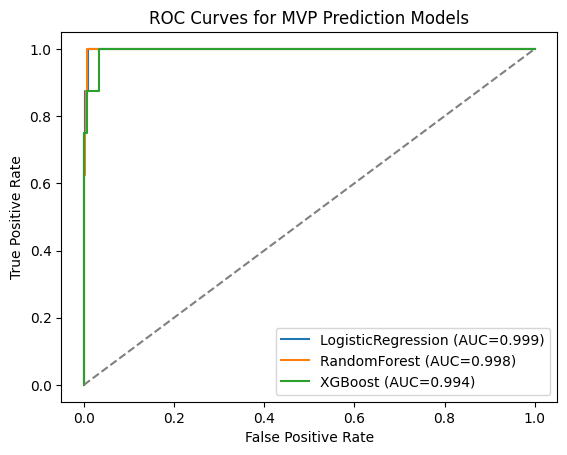

In [6]:
# Plot ROC curves
plt.figure()
for name, model in models.items():
    probas = model.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_te, probas)
    auc = roc_auc_score(y_te, probas)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for MVP Prediction Models")
plt.legend()
plt.show()


ExactExplainer explainer: 14158it [01:14, 168.14it/s]                           


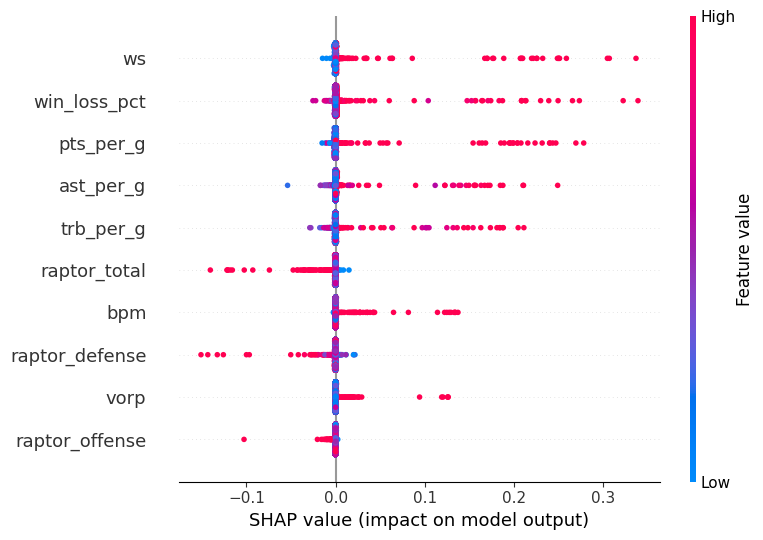

In [7]:
# SHAP interpretability for Logistic Regression
scaler = models["LogisticRegression"].named_steps["scaler"]
estimator = models["LogisticRegression"].named_steps["lr"]
X_scaled = scaler.transform(X_tr)

explainer = shap.Explainer(estimator.predict, masker=shap.maskers.Independent(X_scaled))
shap_vals = explainer(X_scaled)
shap.summary_plot(shap_vals, X_scaled, feature_names=features)
